In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy import ndimage
import random
import os

In [ ]:
def imregionalmax(image, kernel=None):
    """Find the regional max of the image. An approximation of MATLAB's
    imregionalmax function. Result only differs when surrounding pixels
    have the same value as the center.

    Parameters:
    - image: the input image
    - kernel: the size of the neiborhood region, default is 3x3, i.e.
              neighboring 8 pixels.
    Returns:
    - a bitmask image, where '1' indicates local maxima.
    Author:
    - Yu Fang
    References:
    - https://github.com/bhardwajvijay/Utils/blob/master/utils.cpp
    - https://stackoverflow.com/questions/5550290/find-local-maxima-in-grayscale-image-using-opencv
    """
    # dialate the image so that small values are replaced by local max
    local_max = cv2.dilate(image, kernel)
    # non-local max pixels (excluding pixel w/ constant 3x3 neighborhood)
    # will be replaced by local max, so the values will increase. remove them.
    # so the result is either local max or constant neighborhood.
    max_mask = image >= local_max
    # erode the image so that high values are replaced by local min
    local_min = cv2.erode(image, kernel)
    # only local min pixels and pixels w/ constant 3x3 neighborhood
    # will stay the same, otherwise pixels will be replaced by the local
    # min and become smaller. We only take non-local min, non-constant values.
    min_mask = image > local_min
    # boolean logic hack
    #   (local max || constant) && (!local min && !constant)
    # = local max && !local min && !constant
    # = local max && !constant
    return (max_mask & min_mask).astype(np.uint8)

In [ ]:
def est_homography(src, dest):
    """ Compute the homography matrix from (x_src, y_src) to (x_dest, y_dest).
    Parameters:
    - src: (x,y) coordinates of N source pixels, where coordinates are row vectors,
           so the matrix has dimension Nx2 (N>=4).
    - dest: (x,y) coordinates of N destination pixels, where coordinates are row vectors,
            so the matrix has dimension Nx2 (N>=4).
    Returns:
    - the homography matrix such that H @ [x_src, y_src, 1].T = [x_dest, y_dest, 1].T
    Author:
    - Yu Fang
    """
    N = src.shape[0]
    if N != dest.shape[0]:
        raise ValueError("src and diff should have the same dimension")
    src_h = np.hstack((src, np.ones((N, 1))))
    A = np.array([np.block([[src_h[n], np.zeros(3), -dest[n, 0] * src_h[n]],
                            [np.zeros(3), src_h[n], -dest[n, 1] * src_h[n]]])
                  for n in range(N)]).reshape(2 * N, 9)
    [_, _, V] = np.linalg.svd(A)
    # take the right singular vector x corresponding to the least singular value
    # s.t. ||Ax - 0||^2 is minimized
    return V.T[:, 8].reshape(3, 3)

In [ ]:
def apply_homography(H, src):
    """ Apply the homography H to src
    Parameters:
    - H: the 3x3 homography matrix
    - src: (x,y) coordinates of N source pixels, where coordinates are row vectors,
           so the matrix has dimension Nx2 (N>=4).
    Returns:
    - src: (x,y) coordinates of N destination pixels, where coordinates are row vectors,
           so the matrix has dimension Nx2 (N>=4).
    Author:
    - Yu Fang
    """
    src_h = np.hstack((src, np.ones((src.shape[0], 1))))
    dest =  src_h @ H.T
    return (dest / dest[:,[2]])[:,0:2]

In [ ]:
def drawMatches(image1, kp1, image2, kp2, idx_pairs):
    """A wrapper around OpenCV's drawMatches.
    
    Parameters:
    - image1: the first image
    - kp1: *matrix indices* of the keypoints from image 1
           (Nx2 numpy array, where N is the number of keypoints)
    - image2: the second image
    - kp2: *matrix indices* of the keypoints from image 2 
           (Nx2 numpy array, where N is the number of keypoints)
    - idx_pairs: pairs of matching indices, e.g. if kp1[3] 
                 matches kp2[5], then idx_pairs=[[3,5],...]
                 (Kx2 numpy array, where K is the number of matches)
    Returns:
    - an image showing matching points
    Author:
    - Yu Fang
    """
    # note that the coordinates are reversed because the difference
    # between matrix indexing & coordinates.
    keypt1 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp1.tolist()]
    keypt2 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp2.tolist()]
    matches = [cv2.DMatch(pair[0], pair[1], 0, _distance=0) for pair in idx_pairs]
    return cv2.drawMatches(image1, keypt1, image2, keypt2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

In [ ]:
color = cv2.imread('../images/set1/1.jpg')
img = cv2.imread('../images/set1/1.jpg',cv2.IMREAD_GRAYSCALE)
img = np.float32(img)
cimg = cv2.cornerHarris(img,2,3,0.04)


img2 = cv2.imread('../images/set1/2.jpg',cv2.IMREAD_GRAYSCALE)
img2 = np.float32(img2)
cimg2 = cv2.cornerHarris(img2,2,3,0.04)


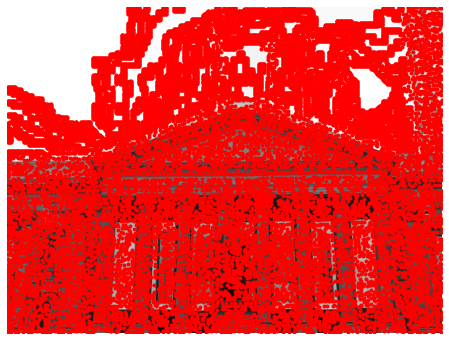

In [ ]:
maxes = imregionalmax(cimg)
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.gray() 
plt.axis('off')
for x,y in np.ndindex(maxes.shape):
    if (maxes[x,y] == 1):
        plt.plot(y, x ,'r.')
plt.show()

In [ ]:
def amns(cimg, n):
    cimg[cimg<0.001*cimg.max()] = [0]
    maxes = imregionalmax(cimg)
    strong = np.sum(maxes)
    maxCimg = np.array([])
    maxCoords = np.empty((0, 2), dtype='int')
    for x,y in np.ndindex(maxes.shape):
        if (maxes[x,y] == 1):
            maxCimg = np.append(maxCimg, cimg[x,y])
            maxCoords = np.append(maxCoords, [[x,y]], axis=0)
    plt.show() 
    r = np.full((strong,3), (np.inf,0,0))
    i = 0
    for x,y in maxCoords:
        suppressing = np.argwhere(cimg[x,y]<.9*cimg)
        dist = np.sum((suppressing - (x, y)) ** 2, axis=1)
        if (len(dist) != 0): r[i] = (np.min(dist), x, y)
        else: r[i] = (np.inf, x, y)
        i+=1
    r = np.array(sorted(r, key = lambda x: x[0]))
    r = r[-n:,1:3]
    return r
    

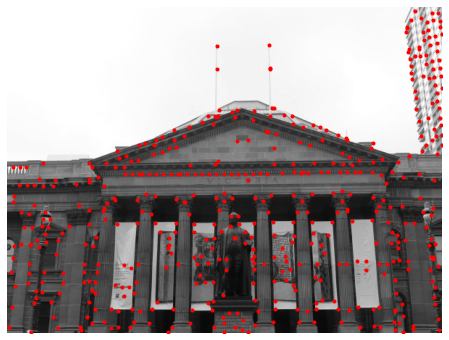

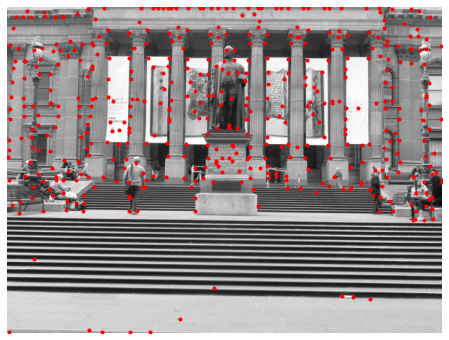

In [ ]:
r = amns(cimg, 500)
r2 = amns(cimg2, 500)
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.gray() 
plt.axis('off')
for x in r:
    plt.plot(x[1], x[0] ,'r.')
plt.show() 
plt.figure(figsize=(8,6))
plt.imshow(img2)
plt.gray() 
plt.axis('off')
for x in r2:
    plt.plot(x[1], x[0] ,'r.')
plt.show() 

In [ ]:
def featureDesc(img, r):
    img = np.pad(img,(20,20), 'constant', constant_values=0)
    desc = np.empty((0, 64))
    for p in r:
        x = int(p[0])
        y = int(p[1])
        window = img[x:x+40,y:y+40]
        window = ndimage.gaussian_filter(window,np.sqrt(2)/2)
        window = window[::5,::5].reshape(1,64)
        mean = np.mean(window)
        std = np.std(window)
        window = (window - mean) / std
        desc = np.append(desc, window, axis=0)
    return desc

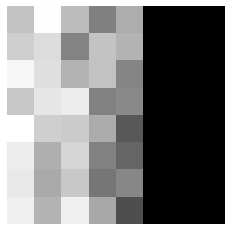

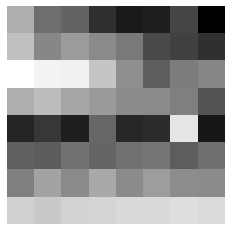

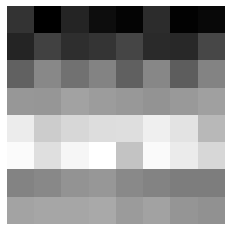

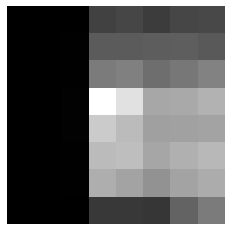

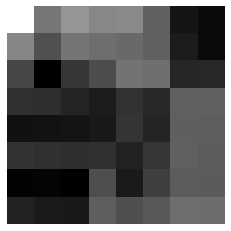

In [ ]:
desc = featureDesc(img, r)
for i in range(5):
    plt.figure(figsize=plt.figaspect(1))
    plt.imshow(desc[i].reshape(8,8))
    plt.gray() 
    plt.axis('off')
    plt.show()   

In [ ]:
def featureMatching(img1, img2, nkps, t):
    cimg1 = cv2.cornerHarris(img1,2,3,0.04)
    kp1 = amns(cimg1, nkps)
    desc1 = featureDesc(img1, kp1)
    
    cimg2 = cv2.cornerHarris(img2,2,3,0.04)
    kp2 = amns(cimg2, nkps)
    desc2 = featureDesc(img2, kp2)
    i1 = 0
    matches = np.empty((0,2))
    for i in range(len(desc1)):
        dists = np.empty((0,2))
        for j in range(len(desc2)):
            if (np.sum(desc2) != 0):
                dist = np.linalg.norm(desc1[i]-desc2[j])
                dists= np.append(dists, [[dist, j]], axis=0)
        dists = np.array(sorted(dists, key = lambda x: x[0]))
        if (dists[0][0]/dists[1][0] < t):
            matches = np.append(matches, [[int(i), int(dists[0,1])]], axis=0)
    return matches, kp1, kp2

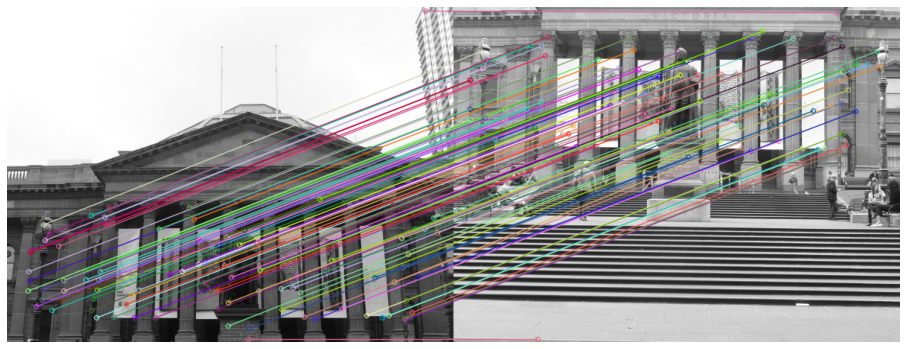

In [ ]:
img1 = cv2.imread('../images/set1/1.jpg',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('../images/set1/2.jpg',cv2.IMREAD_GRAYSCALE)
matches, kp1, kp2 = featureMatching(img1,img2, 500, .7)
img3 = drawMatches(img1, kp1, img2, kp2, matches.astype(int))
plt.figure(figsize=(16,12))
plt.imshow(img3)
plt.gray() 
plt.axis('off')
plt.show()

In [ ]:
def ransac(matches, kp1, kp2, k, t, d):
    bestInliersSrc = np.array([])
    bestInliersDst = np.array([])
    bestMatches = np.array([])
    for j in range(k):
        src = np.empty((4, 2))
        dst = np.empty((4, 2))
        for i in range(4):
            pt = random.choice(matches)
            src[i] = np.flip(kp1[int(pt[0])],0)
            dst[i] = np.flip(kp2[int(pt[1])],0)
        H = est_homography(src, dst)
        Hp = apply_homography(H, np.flip(kp1[matches[:,0].astype(int)],1))
        inliersSrc = np.empty((0,2))
        inliersDst = np.empty((0,2))
        m = np.empty((0,2))
        for i in range(len(Hp)):
            mag = np.sum((Hp[i] - np.flip(kp2[int(matches[i][1])],0)) ** 2)
            if (mag < t):
                inliersSrc = np.append(inliersSrc, [np.flip(kp1[int(matches[i][0])],0)], axis=0)
                inliersDst = np.append(inliersDst, [np.flip(kp2[int(matches[i][1])],0)], axis=0)
                m = np.append(m, [matches[i]], axis=0)
        if (len(inliersSrc) > len(bestInliersSrc)):
            bestInliersSrc = inliersSrc
            bestInliersDst = inliersDst
            bestMatches = m
        if(len(bestInliersSrc) > d):
            bestInliersSrc = bestInliersSrc[d:]
            bestInliersDst = bestInliersDst[d:]
            bestMatches = m[d:]
            break
    return est_homography(bestInliersSrc, bestInliersDst), bestMatches

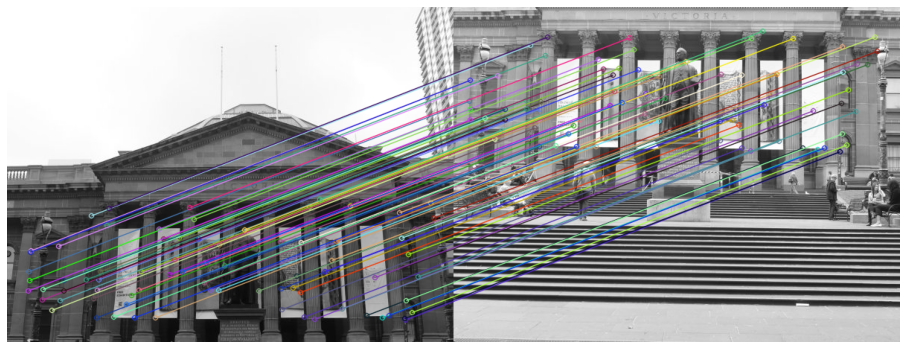

In [ ]:
img1 = cv2.imread('../images/set1/1.jpg',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('../images/set1/2.jpg',cv2.IMREAD_GRAYSCALE)
matches, kp1, kp2 = featureMatching(img1,img2, 500, .7)
H, m = ransac(matches, kp1, kp2, 500, 3, 100)
img3 = drawMatches(img1, kp1, img2, kp2, m.astype(int))
plt.figure(figsize=(16,12))
plt.imshow(img3)
plt.gray() 
plt.axis('off')
plt.show()

In [ ]:
def panoramaStitching(img1, img2, nkps, ft, k, rt, d):
    matches, kp1, kp2 = featureMatching(img1,img2, nkps, ft)
    H,_ = ransac(matches, kp1, kp2, k, rt, d)
    corner1 = apply_homography(H, np.array([[0,0]]))
    corner3 = apply_homography(H, np.array([[0,img1.shape[0]]]))
    corner2 = apply_homography(H, np.array([[img1.shape[1],0]]))
    corner4 = apply_homography(H, np.array([[img1.shape[1],img1.shape[0]]]))
    corners = np.array([corner1[0],corner2[0],corner3[0],corner4[0]])
    x = int(np.amax(np.abs(corners[:,0])))
    y = int(np.amax(np.abs(corners[:,1])))
    Ht = np.dot([[1,0,np.abs(corner1[0][0])],[0,1,np.abs(corner1[0][1])], [0,0,1]], H)
    result = cv2.warpPerspective(img1, Ht, (img1.shape[1] + img2.shape[1] + y, img1.shape[0] + img2.shape[0] + x))
    result[int(np.abs(corner1[0][1])):img2.shape[0] + int(np.abs(corner1[0][1])), int(np.abs(corner1[0][0])):img2.shape[1] + int(np.abs(corner1[0][0]))] = np.maximum(img2, result[int(-1*(corner1[0][1])):img2.shape[0] + int(-1*(corner1[0][1])), int(np.abs(corner1[0][0])):img2.shape[1] + int(np.abs(corner1[0][0]))])
    result = result[~np.all(result == 0, axis=1)]
    result = result[:,~(result==0).all(0)]
    return result


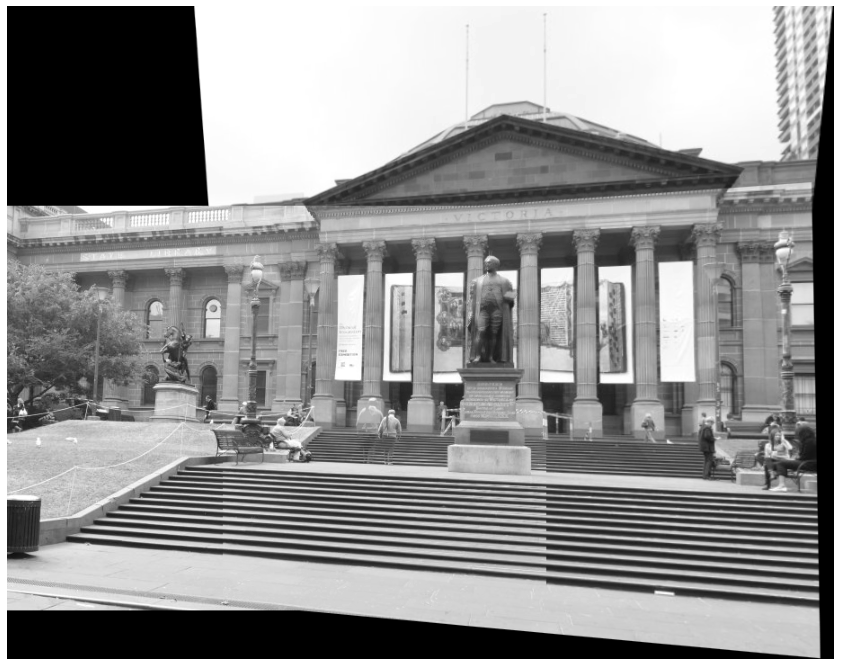

In [ ]:
img1 = cv2.imread('../images/set1/1.jpg',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('../images/set1/2.jpg',cv2.IMREAD_GRAYSCALE)
img3 = panoramaStitching(img1, img2, 500, .7, 500, 3, 100)
img4 = cv2.imread('../images/set1/3.jpg',cv2.IMREAD_GRAYSCALE)
img5 = panoramaStitching(img3, img4, 500, .7, 500, 3, 100)
plt.figure(figsize=(16,12))
plt.imshow(img5)
plt.gray() 
plt.axis('off')
plt.show()

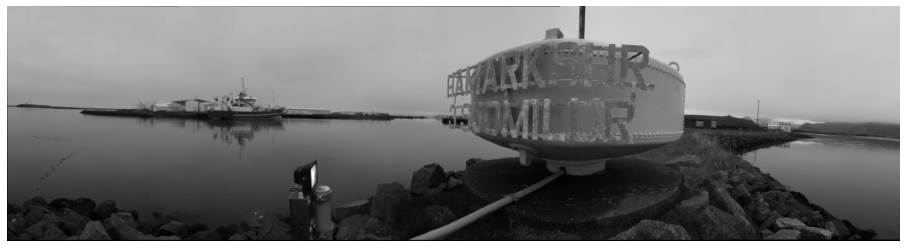

In [ ]:
img1 = cv2.imread('../images/test1/1.jpg',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('../images/test1/2.jpg',cv2.IMREAD_GRAYSCALE)
img3 = panoramaStitching(img1,img2, 500, .7, 500, 3, 500)
img4 = cv2.imread('../images/test1/3.jpg',cv2.IMREAD_GRAYSCALE)
img5 = panoramaStitching(img3,img4, 500, .7, 500, 3, 500)
img6 = cv2.imread('../images/test1/4.jpg',cv2.IMREAD_GRAYSCALE)
img7 = panoramaStitching(img5,img6, 500, .7, 500, 3, 500)
plt.figure(figsize=(16,12))
plt.imshow(img7)
plt.gray() 
plt.axis('off')
plt.show()

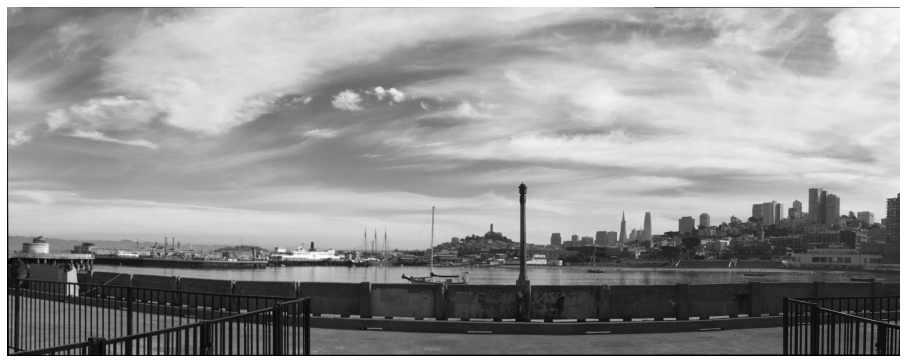

In [ ]:
img1 = cv2.imread('../images/test2/1.jpg',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('../images/test2/2.jpg',cv2.IMREAD_GRAYSCALE)
img3 = panoramaStitching(img1, img2, 500, .7, 500, 3, 1000)
img4 = cv2.imread('../images/test2/3.jpg',cv2.IMREAD_GRAYSCALE)
img5 = panoramaStitching(img3,img4, 500, .7, 500, 3, 1000)
plt.figure(figsize=(16,12))
plt.imshow(img5)
plt.gray() 
plt.axis('off')
plt.show()

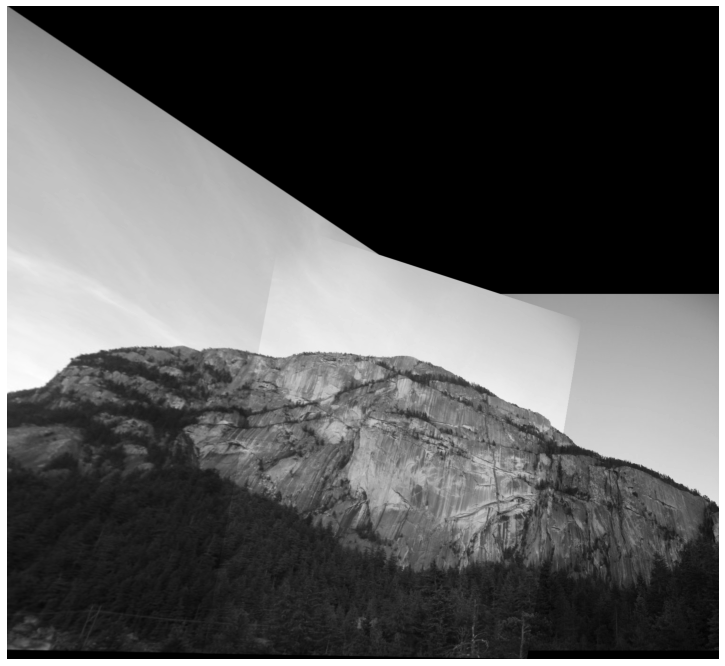

In [ ]:
img1 = cv2.imread('../images/set2/1.jpg',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('../images/set2/2.jpg',cv2.IMREAD_GRAYSCALE)
img3 = panoramaStitching(img1, img2, 500, .7, 500, 3, 1000)
img4 = cv2.imread('../images/set2/3.jpg',cv2.IMREAD_GRAYSCALE)
img5 = panoramaStitching(img3,img4, 500, .7, 500, 3, 1000)
plt.figure(figsize=(16,12))
plt.imshow(img5)
plt.gray() 
plt.axis('off')
plt.show()

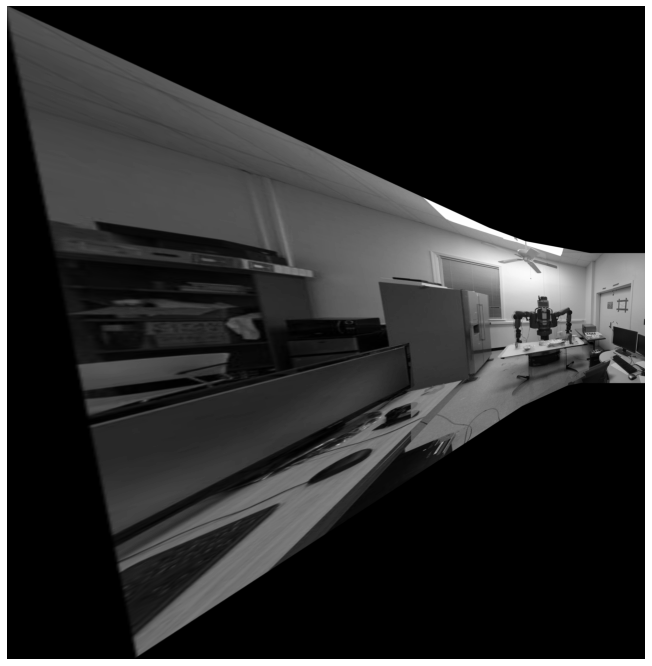

In [ ]:
img1 = cv2.imread('../images/set3/1.jpg',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('../images/set3/2.jpg',cv2.IMREAD_GRAYSCALE)
img3 = panoramaStitching(img1, img2, 500, .7, 500, 3, 1000)
img4 = cv2.imread('../images/set3/3.jpg',cv2.IMREAD_GRAYSCALE)
img5 = panoramaStitching(img3,img4, 500, .7, 500, 3, 1000)
img6 = cv2.imread('../images/set3/4.jpg',cv2.IMREAD_GRAYSCALE)
img7 = panoramaStitching(img5,img6, 500, .7, 500, 3, 1000)
plt.figure(figsize=(16,12))
plt.imshow(img7)
plt.gray() 
plt.axis('off')
plt.show()

In [ ]:
def panoramaCreateAndShow(directory): 
    files = np.sort(np.array(os.listdir(directory)))
    imgs = []
    for i in range(1, len(files) + 1):
        imgs.append(cv2.imread(directory + files[i - 1], cv2.IMREAD_GRAYSCALE))
    imgs = np.array(imgs)
    if (len(imgs) > 2):
        stitched = panoramaStitching(imgs[0], imgs[1], 500, .7, 500, 3, 1000)
        for i in range(3,len(files) + 1):
            stitched = panoramaStitching(stitched, imgs[i - 1], 500, .7, 500, 3, 1000)
        plt.figure(figsize=(16,12))
        plt.imshow(stitched)
        plt.gray() 
        plt.axis('off')
        plt.show()
        

In [ ]:
panoramaCreateAndShow('../images/input/')